# Notebook Imports

In [1]:
from os import walk
from os.path import join 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from PIL import Image
from sklearn.model_selection import train_test_split

from bs4 import BeautifulSoup

# Steps invloved in process:

In [188]:
#1:Gathering all the data
#2:Filtering only the Body of the e-mail of a sample mail and applying the same to all
#3:Using the Generator function and filtering the Body of all the Spam and non-spam mails
#4:Storing the above data in individual DataFrames
#5:Concatenating the Individual DataFrames into "Data"
#6:Data cleaning - Checking for missing values
    #Locating empty emails
    #Removing system file entries from DataFrame
    #Add document IDs to track emails in DataFrame
#7:Exploring and Visualizing data
#8:Natural Language processing:
    #Text-processing:
        #Removing HTML tag
        #Removing punctautions
        #Word stemming
        #Tokenising
        #Removing stop words
#9:Functions for Email processing
#10: Apply Cleaning and Tokenization to all messages:
        #Slicing DataFrames and Series and creating subsets
        #Using logic to slice DataFrames
        #Subsetting a series with an index
#11:Creating Wordcloud
#12:Generate Vocabulary and Dictionary
        #Save the Vocabulary to a csv file
#13:# Generate features and Sparse matrix
        #Creating a DataFrame with one word per column
        #Splitting the data into a training and testing dataset
        #Creating a Sparse matrix for the Training and test data
        #Combine occurences with  the pandas groupby() method
        #Saving the above data into a text file
#14:Checking if there are any missing emails from X_train,X-test in the text file

# Constants

In [151]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0 
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'
WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

# Reading Files

In [4]:
#Gathering the sample data and viewing the E-mail:
stream = open(EXAMPLE_FILE,encoding='latin-1') #differenet systems have diff encoding value, to make it unique we use encoding fn 
message = stream.read()
print(message)
stream.close()

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [5]:
#Gathering the E-mail body alone:
stream = open(EXAMPLE_FILE,encoding='latin-1') #differenet systems have diff encoding value, to make it unique we use encoding fn 

is_body=False
lines=[]

for line in stream:
    if is_body:
        lines.append(line)
    elif line=='\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Function

In [6]:
def my_gens(N):
    for i in range(N):
        yield i**2
for i in my_gens(5):
    print(i,end=',')

0,1,4,9,16,

# Body extraction of all E-mails:

## Task is to create a DF and insert all (spam and non spam) emails into it

In [7]:
def email_body_generator(path):
    for root,dirnames,filenames in walk(path):
        for file_name in filenames:
            filepath=join(root,file_name)
            stream = open(filepath,encoding='latin-1')  

            is_body=False
            lines=[]

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line=='\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            yield file_name,email_body       

In [8]:
def df_from_directory(path,classification):
    rows = []
    row_names = []
    for file_name,email_body in email_body_generator(path):
        rows.append({'MESSAGE':email_body,'CATEGORY':classification})
        row_names.append(file_name)
    return pd.DataFrame(rows,index=row_names)

In [9]:
spam_emails = df_from_directory(SPAM_1_PATH,SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH,SPAM_CAT))
spam_emails.head()
nonspam_emails = df_from_directory(EASY_NONSPAM_1_PATH,HAM_CAT)
nonspam_emails = nonspam_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT))
nonspam_emails.shape

(3901, 2)

In [10]:
#DataFrame with both spam and non-spam e-mails:
data = pd.concat([spam_emails,nonspam_emails])
print('Shape of the data',data.shape)
data.tail()

Shape of the data (5799, 2)


MESSAGE  \
01396.61983fbe6ec43f55fd44e30fce24ffa6  http://news.bbc.co.uk/1/hi/england/2515127.stm...   
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7  > >-- be careful when using this one.) Also, t...   
01398.169b51731fe569f42169ae8f948ec676  >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...   
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896  So then, "Mark Hammond" <mhammond@skippinet.co...   
01400.f897f0931e461e7b2e964d28e927c35e  Hi there,\n\n\n\nNow this is probably of no us...   

                                        CATEGORY  
01396.61983fbe6ec43f55fd44e30fce24ffa6         0  
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7         0  
01398.169b51731fe569f42169ae8f948ec676         0  
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896         0  
01400.f897f0931e461e7b2e964d28e927c35e         0

# 6 Data cleaning - Checking for missing values

In [11]:
#Check if there are any null values:
data['MESSAGE'].isnull().values.any()

False

In [12]:
#The no. of email with null values:
data['MESSAGE'].isnull().values.any().sum()

0

In [13]:
#Checking if the E-mail is empty?:
(data['MESSAGE'].str.len()==0).any()

True

In [14]:
#The number of E-mails with empty string:
(data['MESSAGE'].str.len()==0).any().sum()

1

### Locating empty emails

In [15]:
data[data['MESSAGE'].str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [16]:
#Used to access Rows in a DF:
data[4777:4779]

MESSAGE  \
00379.cb86b033e4fc334deda622bcc37e6293  On Tue, Aug 13, 2002 at 10:03:14AM +0100, Dami...   
00380.d78a42167264ab6adbd1b5eb1f452e9a  On Tue, Aug 13, 2002 at 09:55:49AM +0100, Ryan...   

                                        CATEGORY  
00379.cb86b033e4fc334deda622bcc37e6293         0  
00380.d78a42167264ab6adbd1b5eb1f452e9a         0

In [17]:
#To get the index where the cmds row is stored:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

# Removing system file entries from DataFrame

In [18]:
#The below method can be used to remove rows as well:
data=data.drop(['cmds'])

In [19]:
data.shape

(5796, 2)

# Add document IDs to track emails in DataFrame

In [20]:
document_ids = range(0,len(data.index))
data['DOC_ID'] = document_ids

In [21]:
data['FILE_NAME'] = data.index

In [22]:
data.set_index('DOC_ID',inplace=True) # The inplace is usedx to update data

In [23]:
data.head()

MESSAGE  CATEGORY  \
DOC_ID                                                                
0       <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...         1   
1       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
2       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
3       ##############################################...         1   
4       I thought you might like these:\n\n1) Slim Dow...         1   

                                     FILE_NAME  
DOC_ID                                          
0       00001.7848dde101aa985090474a91ec93fcf0  
1       00002.d94f1b97e48ed3b553b3508d116e6a09  
2       00003.2ee33bc6eacdb11f38d052c44819ba6c  
3       00004.eac8de8d759b7e74154f142194282724  
4       00005.57696a39d7d84318ce497886896bf90d

In [24]:
data.tail()

MESSAGE  CATEGORY  \
DOC_ID                                                                
5791    http://news.bbc.co.uk/1/hi/england/2515127.stm...         0   
5792    > >-- be careful when using this one.) Also, t...         0   
5793    >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...         0   
5794    So then, "Mark Hammond" <mhammond@skippinet.co...         0   
5795    Hi there,\n\n\n\nNow this is probably of no us...         0   

                                     FILE_NAME  
DOC_ID                                          
5791    01396.61983fbe6ec43f55fd44e30fce24ffa6  
5792    01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7  
5793    01398.169b51731fe569f42169ae8f948ec676  
5794    01399.ca6b00b7b341bbde9a9ea3dd6a7bf896  
5795    01400.f897f0931e461e7b2e964d28e927c35e

# Save to Files using Pandas

In [25]:
#Copying the above data into a new JSON file:
#data.to_json(DATA_JSON_FILE) 

# 7:Exploring and Visualizing data 

## Visualizing number of spam messages (Pie chart)

In [26]:
data['CATEGORY'].value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [27]:
#Taking counts of each set of mails:
amount_of_spam =  data['CATEGORY'].value_counts()[1]
amount_of_ham = data['CATEGORY'].value_counts()[0]

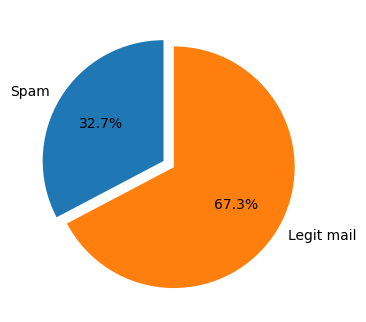

In [28]:
#Visualizing the above data in a  pie chart:
category_names = ['Spam','Legit mail']
sizes = [amount_of_spam,amount_of_ham]
plt.figure(figsize=(4,4),dpi=100) #dpi- pixels
plt.pie(sizes,labels=category_names,startangle=90,autopct='%1.1f%%',explode=[0,0.1])
plt.show()

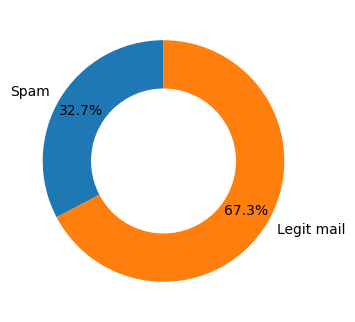

In [29]:
#Visualizing the above data in a Donut chart:
category_names = ['Spam','Legit mail']
sizes = [amount_of_spam,amount_of_ham]
plt.figure(figsize=(4,4),dpi=100) #dpi- pixels
plt.pie(sizes,labels=category_names,startangle=90,autopct='%1.1f%%',pctdistance=0.8)

#Draw circle:
centre_circle = plt.Circle((0,0),radius=0.6,fc='white')
plt.gca().add_artist(centre_circle) # adding the circle to the figure

plt.show()

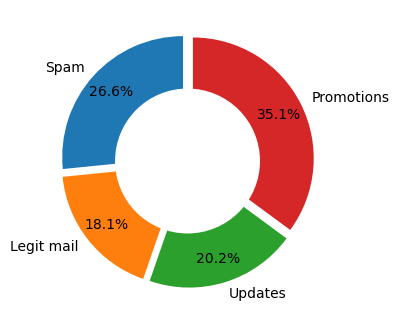

In [30]:
#Modifying the previous Donut chart:
category_names = ['Spam','Legit mail','Updates','Promotions']
sizes = [25,17,19,33]
offset=[0.05,0.05,0.05,0.05]
plt.figure(figsize=(4,4),dpi=100) #dpi- pixels
plt.pie(sizes,labels=category_names,startangle=90,autopct='%1.1f%%',pctdistance=0.8,explode=offset)

#Draw circle:
centre_circle = plt.Circle((0,0),radius=0.6,fc='white')
plt.gca().add_artist(centre_circle) # adding the circle to the figure

plt.show()

#  8:Natural Language processing 

### Text pre-processing

In [31]:
#Text preprocessing involves 5 different steps:
#Tokenizing
#Removing stopped words
#Word stemming
#Removing HTML tags
#Removing punctuations
msg='All work and no play makes jack a dull boy'

# Downloading the NLTK resources (Tokenizer and Stop words)

In [32]:
nltk.download('punkt') #For tokenizing words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Danush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [33]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Danush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Danush\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\Danush\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

# Tokenizing

In [35]:
msg='All work and no play makes jack a dull boy'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

# Removing stop words

In [36]:
stop_words = set(stopwords.words('english'))

In [37]:
msg='All work and no play makes jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []
for i in words:
    if i not in stop_words:
        filtered_words.append(i)

In [38]:
filtered_words

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']

## Removing Punctations and Word Stemming:

In [39]:
msg='All work and no play makes jack a dull boy. To be or not to be. \
    Nobody expects the spanish inquistion!'
words = word_tokenize(msg.lower())
#stemmer = PorterStemmer() #PorterStemmer is an algo written by Porter
stemmer = SnowballStemmer('english')

filtered_words = []
for i in words:
    if i not in stop_words and i.isalpha(): #isalpha is used for removing punctuations
        stemmed_words = stemmer.stem(i)
        filtered_words.append(stemmed_words)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquist']


## Removing HTML tags

In [40]:
#Another way to access row:
data.at[3,'MESSAGE'] #Takes index and column name as parameters
soup = BeautifulSoup(data.at[3,'MESSAGE'],'html.parser')
print(soup.prettify()) #prettify is used to viewing it in a prettier manner

##################################################

#                                                #

#                 Adult Club                     #

#           Offers FREE Membership               #

#                                                #

##################################################



&gt;&gt;&gt;&gt;&gt;  INSTANT ACCESS TO ALL SITES NOW

&gt;&gt;&gt;&gt;&gt;  Your User Name And Password is.

&gt;&gt;&gt;&gt;&gt;  User Name: zzzz@spamassassin.taint.org

&gt;&gt;&gt;&gt;&gt;  Password: 760382



5 of the Best Adult Sites on the Internet for FREE!

---------------------------------------

NEWS 08/18/02

With just over 2.9 Million Members that signed up for FREE, Last month there were 721,184 New

Members. Are you one of them yet???

---------------------------------------

Our Membership FAQ



Q. Why are you offering free access to 5 adult membership sites for free?

A. I have advertisers that pay me for ad space so you don't have to pay for membership.



Q.

In [41]:
soup.get_text() # Removes all the HTML tag

"##################################################\n\n#                                                #\n\n#                 Adult Club                     #\n\n#           Offers FREE Membership               #\n\n#                                                #\n\n##################################################\n\n\n\n>>>>>  INSTANT ACCESS TO ALL SITES NOW\n\n>>>>>  Your User Name And Password is.\n\n>>>>>  User Name: zzzz@spamassassin.taint.org\n\n>>>>>  Password: 760382\n\n\n\n5 of the Best Adult Sites on the Internet for FREE!\n\n---------------------------------------\n\nNEWS 08/18/02\n\nWith just over 2.9 Million Members that signed up for FREE, Last month there were 721,184 New\n\nMembers. Are you one of them yet???\n\n---------------------------------------\n\nOur Membership FAQ\n\n\n\nQ. Why are you offering free access to 5 adult membership sites for free?\n\nA. I have advertisers that pay me for ad space so you don't have to pay for membership.\n\n\n\nQ. Is it true m

# 9:Function for E-mail processing : 

### (above steps are comprised into this)

In [42]:
def clean_message(message,stemmer=PorterStemmer(),stop_words=set(stopwords.words('english'))):
    
    #Converting content into lower case and splitting into individual words:
    words = word_tokenize(message.lower())
    
    filtered_words =[]
    
    for word in words:
        
        #Appending if the word is not a stop word and excluding punctutations:
        if word not in stop_words and word.isalpha():
            
            #Converting individual identical words into stemmed words:
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [43]:
#This clears HTML tag in addition to the above one:
def clean_msg_no_html(message,stemmer=PorterStemmer(),stop_words=set(stopwords.words('english'))):
    
    soup = BeautifulSoup(message,'html.parser')
    cleaned_text = soup.get_text()
    
    #Converting content into lower case and splitting into individual words:
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words =[]
    
    for word in words:
        
        #Appending if the word is not a stop word and excluding punctutations:
        if word not in stop_words and word.isalpha():
            #filtered_words.append(word)
            #Converting individual identical words into stemmed words:
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [44]:
clean_msg_no_html(data.at[2,'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

# Apply Cleaning and Tokenization to all messages:

## Slicing DataFrames and Series and creating subsets

In [45]:
#UNDERSTANDINGS:
#Another method of accessing rows:
data.iat[2,0] #2 is position of row #0 is column number

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

In [46]:
data.iloc[0:2]

MESSAGE  CATEGORY  \
DOC_ID                                                                
0       <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...         1   
1       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   

                                     FILE_NAME  
DOC_ID                                          
0       00001.7848dde101aa985090474a91ec93fcf0  
1       00002.d94f1b97e48ed3b553b3508d116e6a09

In [47]:
#Used to get only the Body of Email of the below rows:
data.MESSAGE.iloc[0:7]

DOC_ID
0    <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...
1    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
2    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
3    ##############################################...
4    I thought you might like these:\n\n1) Slim Dow...
5    A POWERHOUSE GIFTING PROGRAM You Don't Want To...
6    Help wanted.  We are a 14 year old fortune 500...
Name: MESSAGE, dtype: object

In [48]:
first_emails = data.MESSAGE.iloc[0:7]
nested_emails = first_emails.apply(clean_message)

In [49]:
flat_list = []
for email in nested_emails:
    for word in email:
        flat_list.append(word)
        
#Alternative for nested for-loops:
#flat_list = [word for email in nested_emails for word in email]

len(flat_list)

780

In [50]:
#END OF UNDERSTANDINGS:

In [51]:
#This creates a Series where all the IDs and its corresponding words are stored: 
nested_emails = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\Danush\anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [52]:
nested_list = nested_emails

In [53]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [54]:
data.head()

MESSAGE  CATEGORY  \
DOC_ID                                                                
0       <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...         1   
1       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
2       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
3       ##############################################...         1   
4       I thought you might like these:\n\n1) Slim Dow...         1   

                                     FILE_NAME  
DOC_ID                                          
0       00001.7848dde101aa985090474a91ec93fcf0  
1       00002.d94f1b97e48ed3b553b3508d116e6a09  
2       00003.2ee33bc6eacdb11f38d052c44819ba6c  
3       00004.eac8de8d759b7e74154f142194282724  
4       00005.57696a39d7d84318ce497886896bf90d

## Using logic to slice DataFrames

In [55]:
#UNDERSTANDINGS

In [56]:
data[data.CATEGORY == 1].head()

MESSAGE  CATEGORY  \
DOC_ID                                                                
0       <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...         1   
1       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
2       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
3       ##############################################...         1   
4       I thought you might like these:\n\n1) Slim Dow...         1   

                                     FILE_NAME  
DOC_ID                                          
0       00001.7848dde101aa985090474a91ec93fcf0  
1       00002.d94f1b97e48ed3b553b3508d116e6a09  
2       00003.2ee33bc6eacdb11f38d052c44819ba6c  
3       00004.eac8de8d759b7e74154f142194282724  
4       00005.57696a39d7d84318ce497886896bf90d

In [57]:
data[data.CATEGORY == 1].tail()

MESSAGE  CATEGORY  \
DOC_ID                                                                
1891    <html>\n\n<head>\n\n<meta http-equiv="content-...         1   
1892    This is a multi-part message in MIME format.\n...         1   
1893    Dear Subscriber,\n\n\n\nIf I could show you a ...         1   
1894    ****Mid-Summer Customer Appreciation SALE!****...         1   
1895    ATTN:SIR/MADAN      \n\n\n\n                  ...         1   

                                     FILE_NAME  
DOC_ID                                          
1891    01396.e80a10644810bc2ae3c1b58c5fd38dfa  
1892    01397.f75f0dd0dd923faefa3e9cc5ecb8c906  
1893    01398.8ca7045aae4184d56e8509dc5ad6d979  
1894    01399.2319643317e2c5193d574e40a71809c2  
1895    01400.b444b69845db2fa0a4693ca04e6ac5c5

In [58]:
#End of Understandings

In [59]:
#Storing the index value of both spam and non-spam messages:
doc_ids_spam =  data[data.CATEGORY == 1].index
doc_ids_ham  =  data[data.CATEGORY == 0].index

In [60]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

### Subsetting a series with an index

In [61]:
#Stored a series containing DOC_ID and the corresponding filtered words:
nested_list_spam = nested_emails.loc[doc_ids_spam]
nested_list_ham = nested_emails.loc[doc_ids_ham]

In [62]:
flat_list_ham = [item for subset in nested_list_ham for item in subset]

#The value_counts() is used to get the number of times each word has 
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] #Total number of unique words in non-spam emails
normal_words[:10] # Most repeated top 10 words 

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [63]:
flat_list_spam = [item for subset in nested_list_spam for item in subset]

#The value_counts() is used to get the number of times each word has 
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] #Total number of unique words in spam emails
spammy_words[:10] # Most repeated top 10 words 

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

In [64]:
#Installing additional packages :
#The below package is installed using Anaconda Navigator -> Open Terminal
#conda install -c conda-forge wordcloud

# Creating a WordCloud

In [65]:
#Understandings:

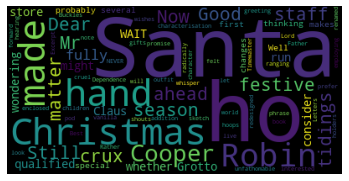

In [66]:
#Creating a Word cloud:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [67]:
#Assigning a novel(imported in NLTK) to a variable: 
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')

In [68]:
len(example_corpus)

260819

In [69]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ''.join(word_list)

In [70]:
#The entire novel was once a corpus type, then a token and now a string 
#Conversion has been done for givivg it as inputs to Word cloud
novel_as_string

'[MobyDickbyHermanMelville1851]ETYMOLOGY.(SuppliedbyaLateConsumptiveUshertoaGrammarSchool)ThepaleUsher--threadbareincoat,heart,body,andbrain;Iseehimnow.Hewaseverdustinghisoldlexiconsandgrammars,withaqueerhandkerchief,mockinglyembellishedwithallthegayflagsofalltheknownnationsoftheworld.Helovedtodusthisoldgrammars;itsomehowmildlyremindedhimofhismortality."Whileyoutakeinhandtoschoolothers,andtoteachthembywhatnameawhale-fishistobecalledinourtongueleavingout,throughignorance,theletterH,whichalmostalonemakeththesignificationoftheword,youdeliverthatwhichisnottrue."--HACKLUYT"WHALE....Sw.andDan.HVAL.Thisanimalisnamedfromroundnessorrolling;forinDan.HVALTisarchedorvaulted."--WEBSTER\'SDICTIONARY"WHALE....ItismoreimmediatelyfromtheDut.andGer.WALLEN;A.S.WALW-IAN,toroll,towallow."--RICHARDSON\'SDICTIONARYKETOS,GREEK.CETUS,LATIN.WHOEL,ANGLO-SAXON.HVALT,DANISH.WAL,DUTCH.HWAL,SWEDISH.WHALE,ICELANDIC.WHALE,ENGLISH.BALEINE,FRENCH.BALLENA,SPANISH.PEKEE-NUEE-NUEE,FEGEE.PEKEE-NUEE-NUEE,ERROMANGOAN.EXTRACTS

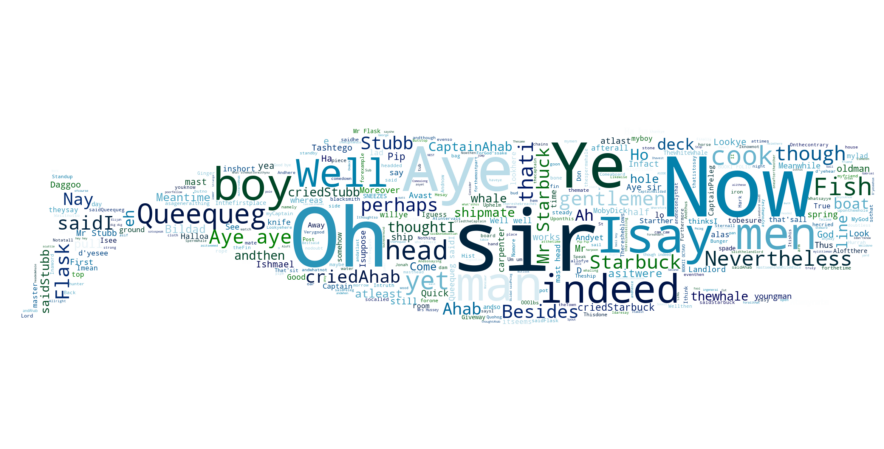

In [71]:
#Creating a Word cloud:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB',size=icon.size,color=(255,255,255)) #Masking layer
image_mask.paste(icon,box=icon) #pasting the icon in image_mask

rgb_array = np.array(image_mask) #converts the image object to an array

word_cloud = WordCloud(mask=rgb_array,background_color='white',max_words=400,colormap='ocean')

word_cloud.generate(novel_as_string)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [72]:
#Creating the same for shakespeare:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ''.join(word_list)

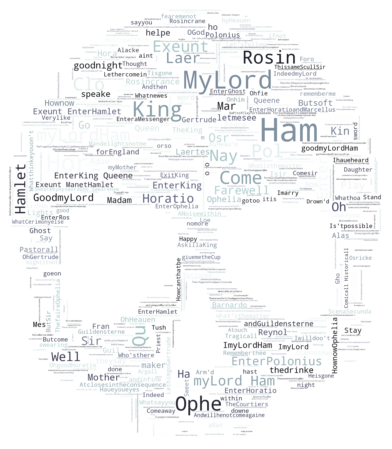

In [73]:
#Creating a Word cloud:
skull_icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB',size=skull_icon.size,color=(255,255,255)) #Masking layer
image_mask.paste(skull_icon,box=skull_icon) #pasting the icon in image_mask

rgb_array = np.array(image_mask) #converts the image object to an array

word_cloud = WordCloud(mask=rgb_array,background_color='white',max_words=600,colormap='bone')

word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [74]:
#End of UNDERSTANDINGS

# Word cloud of spam and ham messages

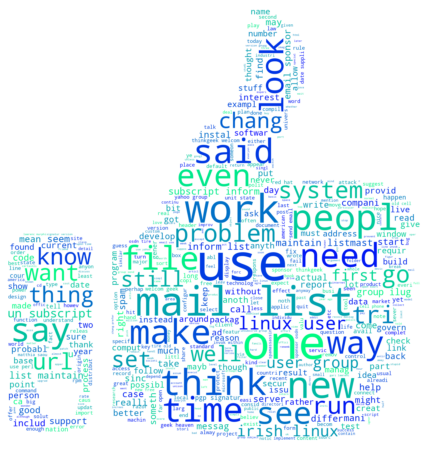

In [75]:
#Creating a Word cloud:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB',size=icon.size,color=(255,255,255)) #Masking layer
image_mask.paste(icon,box=icon) #pasting the icon in image_mask

rgb_array = np.array(image_mask) #converts the image object to an array
word_cloud = WordCloud(mask=rgb_array,background_color='white',max_words=500,colormap='winter')

#Generating the string for input:
ham_str = ' '.join(flat_list_ham) 

#Supplying the input to the Wordcloud
word_cloud.generate(ham_str)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

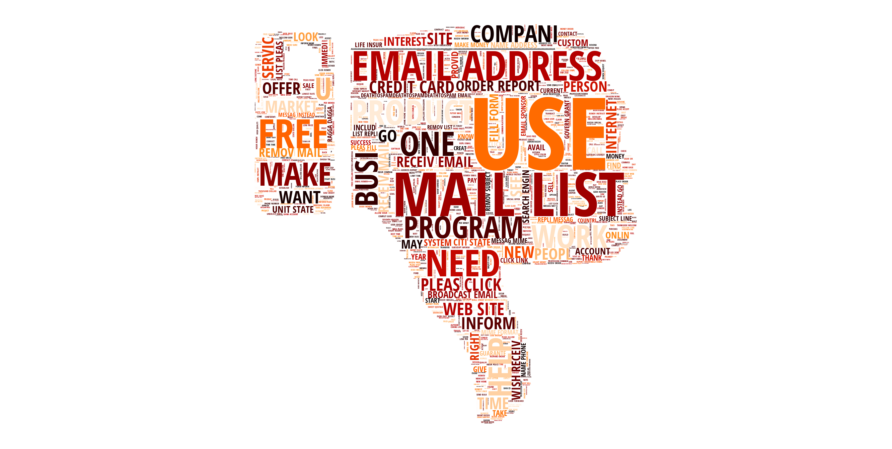

In [76]:
#Creating a Word cloud:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB',size=icon.size,color=(255,255,255)) #Masking layer
image_mask.paste(icon,box=icon) #pasting the icon in image_mask

rgb_array = np.array(image_mask) #converts the image object to an array
word_cloud = WordCloud(mask=rgb_array,background_color='white',max_words=2000,colormap='gist_heat',
                       max_font_size=300,font_path=CUSTOM_FONT_FILE)

#Generating the string for input:
ham_str = ' '.join(flat_list_spam) 

#Supplying the input to the Wordcloud
word_cloud.generate(ham_str.upper())

plt.figure(figsize=[16,8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [77]:
#INFO:USE FONTAWESOME.COM for icons like thumbs up and thumbs down

# Generate Vocabulary and Dictionary

In [78]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\Danush\anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [79]:
len(flat_stemmed_list)

759578

In [80]:
#To get the unique words in the entire list of words:
unique_words = pd.Series(flat_stemmed_list).value_counts() #To get number of unique words
print('The number of Unique words:',unique_words.shape[0])
unique_words.head()

The number of Unique words: 27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [81]:
#To get the top few frequently occuring words:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words:\n',frequent_words[0:10])

Most common words:
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


In [103]:
#vocab stores to few frequently occuring words:
word_ids = list(range(0,VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD':frequent_words.index.values},index=word_ids)#VOCAB_WORD is a column name
vocab.index.name = 'WORD_ID'

# Save the VOCAB to a csv file

In [83]:
#vocab.to_csv(WORD_ID_FILE,index_label='WORD_ID',header='VOCAB_WORD')
                                        #or
#vocab.to_csv(WORD_ID_FILE,index_label=vocab.index.name,header=vocab.VOCAB_WORD.name) --- File already exists

In [84]:
#UNDERSTANDINGS:
any(vocab.VOCAB_WORD =='http')#CHecking if the word is present in vocab

True

In [85]:
'http' in set(vocab.VOCAB_WORD)#CHecking if the word is present in vocab (efficient way)

True

In [86]:
#EMAIL WITH THE MOST NUMBER OF WORDS:
clean_emails_length = []
for emails in stemmed_nested_list:
    clean_emails_length.append(len(emails))

In [87]:
max(clean_emails_length)

7671

In [88]:
#Finding the position in which the largest email is stored:
print('The location of the largest email is:',np.argmax(clean_emails_length))
print('The location of the smallest email is:',np.argmin(clean_emails_length))

The location of the largest email is: 5775
The location of the smallest email is: 22


In [89]:
#END OF UNDERSTANDINGS:

# Generate features and Sparse matrix

### Creating a DataFrame with one word per column

In [90]:
type(stemmed_nested_list)

pandas.core.series.Series

In [91]:
stemmed_nested_list.to_list() # Converting the series to 2D list 

[['save',
  'life',
  'insur',
  'spend',
  'life',
  'quot',
  'save',
  'g',
  'famili',
  'financi',
  'secur',
  'import',
  'life',
  'quot',
  'save',
  'ke',
  'buy',
  'life',
  'insur',
  'simpl',
  'afford',
  'provid',
  'free',
  'access',
  'best',
  'compani',
  'lowest',
  'rate',
  'life',
  'quot',
  'save',
  'fast',
  'save',
  'money',
  'let',
  'us',
  'help',
  'get',
  'start',
  'best',
  'ue',
  'countri',
  'new',
  'coverag',
  'save',
  'hundr',
  'even',
  'usand',
  'dollar',
  'request',
  'free',
  'quot',
  'lifequot',
  'save',
  'servic',
  'take',
  'less',
  'minut',
  'complet',
  'shop',
  'compar',
  'save',
  'type',
  'life',
  'insur',
  'click',
  'free',
  'quot',
  'protect',
  'famili',
  'best',
  'invest',
  'r',
  'make',
  'receipt',
  'email',
  'error',
  'wish',
  'remov',
  'list',
  'pleas',
  'click',
  'type',
  'remov',
  'resid',
  'state',
  'prohibit',
  'solicit',
  'ce',
  'pleas',
  'disregard',
  'email'],
 ['fight',
  

In [92]:
#Converts the 2D list to a df with one word in each column
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.to_list())

In [93]:
word_columns_df

0        1          2         3           4         5        6     \
0        save     life      insur     spend        life      quot     save   
1       fight     risk     cancer      http        slim  guarante     lose   
2       fight     risk     cancer      http        slim  guarante     lose   
3       adult     club      offer      free  membership   instant   access   
4     thought    might       like      slim    guarante      lose       lb   
...       ...      ...        ...       ...         ...       ...      ...   
5791     http   bizarr    collect      stuf        anim     could    fetch   
5792     care      use        one      also      realli      cute    thing   
5793       sm     skip  montanaro     write      jeremi       put    anoth   
5794     mark  hammond       like     given        zodb     sound  attract   
5795       hi  probabl        use  whatsoev        also   problem   regard   

         7         8        9     ...  7661  7662  7663  7664  7665  7666  \
0           g    famili  financi  ...  None  None  None  None  None  None   
1          lb       day     http  ...  None  None  None  None  None  None   
2          lb       day     http  ...  None  None  None  None  None  None   
3        site      user     name  ...  None  None  None  None  None  None   
4         day      http    fight  ...  None  None  None  None  None  None   
...       ...       ...      ...  ...   ...   ...   ...   ...   ...   ...   
5791     sold   cornwal   museum  ...  None  None  None  None  None  None   
5792  japanes        av     girl  ...  None  None  None  None  None  None   
5793      way  interest     hear  ...  None  None  None  None  None  None   
5794    would    packag    hundr  ...  None  None  None  None  None  None   
5795   nvidia       two   machin  ...  None  None  None  None  None  None   

      7667  7668  7669  7670  
0     None  None  None  None  
1     None  None  None  None  
2     None  None  None  None  
3     None  None  None  None  
4     None  None  None  None  
...    ...   ...   ...   ...  
5791  None  None  None  None  
5792  None  None  None  None  
5793  None  None  None  None  
5794  None  None  None  None  
5795  None  None  None  None  

[5796 rows x 7671 columns]

# Splitting the data into a training and testing dataset

In [95]:
X_train,X_test,y_train,y_test = train_test_split(word_columns_df,data.CATEGORY,test_size=0.3,random_state=42)
#Y values which we are trying to predict are the Categories

In [97]:
print('Number of training samples:',X_train.shape[0])
print('Fraction of the training samples:',X_train.shape[0]/word_columns_df.shape[0])

Number of training samples: 4057
Fraction of the training samples: 0.6999654934437544


# Creating a Sparse matrix for the Training data

In [110]:
#Storing all the top few frequently occuring words to the word_index
word_index = pd.Index(vocab.VOCAB_WORD) 

In [113]:
word_index.get_loc('thu') 

393

In [124]:
def make_sparse_matrix(df,indexed_words,labels):
    #Creating a Df consisting of Each word in X_train as seperate row and its occurence ,Word_Id from Word_index ,DOC_ID of 
    #each mail
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i,j]
            if word in word_set:
                
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL':category,'DOC_ID':doc_id,'OCCURENCE':1,'WORD_ID':word_id}
                dict_list.append(item)
                
    return pd.DataFrame(dict_list)
        

In [125]:
sparse_train_df = make_sparse_matrix(X_train,word_index,y_train)

In [127]:
sparse_train_df[0:7]

LABEL  DOC_ID  OCCURENCE  WORD_ID
0      0    4844          1      265
1      0    4844          1     1243
2      0    4844          1      503
3      0    4844          1      308
4      0    4844          1      254
5      0    4844          1      879
6      0    4844          1       32

# Combine occurences with  the pandas groupby() method

In [141]:
#This is used to group the below columns to find the occurences by removing duplicates:
train_grouped = sparse_train_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()

In [143]:
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [144]:
train_grouped = train_grouped.reset_index() #To display the DOC_ID in all rows

In [145]:
train_grouped.head()

DOC_ID  WORD_ID  LABEL  OCCURENCE
0       0        2      1          1
1       0        3      1          2
2       0        4      1          1
3       0        7      1          3
4       0       11      1          1

In [146]:
train_grouped.shape

(258350, 4)

In [149]:
#To get the corresponding word:
vocab.at[11,'VOCAB_WORD']

'make'

### Save training data as .txt file

In [154]:
#np.savetxt(TRAINING_DATA_FILE,train_grouped,fmt='%d') -creating a txt File fmt=Format

In [153]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

### Creating a Sparse matrix for the test dataset

In [155]:
sparse_test_df = make_sparse_matrix(X_test,word_index,y_test)

In [156]:
#Grouping the values to eliminate duplicates:
test_grouped = sparse_test_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum().reset_index()

In [157]:
test_grouped.shape[0]

117772

### Saving the test data as .txt file

In [160]:
#Creating a text file which stores test sparse matrix:
#np.savetxt(TEST_DATA_FILE,test_grouped,fmt='%d')

# Checking if there are any missing emails in text files

In [162]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [169]:
len(X_train)-len(train_doc_ids) #Gives the number of emails which has been neglected automatically

44

In [180]:
set(X_test.index.values) - test_doc_ids

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

In [183]:
#INFO:
data.MESSAGE[134] #The following email is ignored since it is encoded.

'------=_NextPart_000_00E8_85C13B1D.B7243B86\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nPGh0bWw+DQoNCjxib2R5IGJnY29sb3I9IiNGRkZGRkYiIHRleHQ9IiMwMDAw\n\nMDAiPiANCjxwIGFsaWduPSJjZW50ZXIiPjxhIGhyZWY9Imh0dHA6Ly93d3cu\n\nZGlyZWN0d2Vic3RvcmUuY29tL3RveXMvaW5kZXguaHRtbCI+PGltZyBzcmM9\n\nImh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL21waWMuanBnIiB3aWR0\n\naD0iNTAwIiBoZWlnaHQ9IjMzOSIgYm9yZGVyPSIwIj48L2E+PGJyPiANCjxm\n\nb250IHNpemU9IjMiIGZhY2U9IkFyaWFsLCBIZWx2ZXRpY2EsIHNhbnMtc2Vy\n\naWYiPjxhIGhyZWY9Imh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL3Rv\n\neXMvaW5kZXguaHRtbCI+PGI+RU5URVIgDQpOT1cgaWYgeW91IGFyZSAxOCBh\n\nbmQgb3ZlcjwvYj48L2E+PC9mb250PjwvcD4gDQo8cCBhbGlnbj0iY2VudGVy\n\nIj48Zm9udCBmYWNlPSJBcmlhbCwgSGVsdmV0aWNhLCBzYW5zLXNlcmlmIiBz\n\naXplPSI0IiBjb2xvcj0iI0ZGMDAwMCI+PGI+U1BFQ0lBTCANCk9GRkVSPGJy\n\nPiANCjxmb250IHNpemU9IjUiPjMwIERheXMgPGk+RlJFRSBhY2Nlc3M8L2k+\n\nIDwvZm9udD48YnI+IA0KdG8gdGhlIGxhcmdlc3QgQWR1bHRzaXRlIG9uIHRo\n\nZSB3ZWIuPGJyPiANCjwvYj4gPG